In [ ]:
# default_exp samplers.protocol_samplers

# Protocol Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction protocols

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition, make_hash, unpack
from qsam.fault_generators import Depolar
from qsam.protocol import iterate
from qsam.samplers.constants import *
from qsam.samplers.subset_helper import *
import qsam.samplers.callbacks as cb

import numpy as np
from tqdm.notebook import tqdm # ask if we are in notebook or not: if not use normal tqdm.

from anytree import RenderTree, NodeMixin
from anytree.exporter import JsonExporter
from anytree.importer import JsonImporter, DictImporter

In [ ]:
#export

class Sampler:
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
        self.is_setup = False
        
    def setup(self, sample_range, err_params):
        self.partitions = {circuit_hash: [partition(circuit, GATE_GROUPS[k]) for k in err_params.keys()]
                           for circuit_hash, circuit in self.protocol._circuits.items()}
        self.p_phys = [s * np.array(list(err_params.values())) for s in sample_range]
        
        self.cnts = np.zeros(len(sample_range))
        self.fail_cnts = np.zeros(len(sample_range))
        self.is_setup = True
        
    def stats(self, p_idx=None, var_fn=math.Wilson_var):
        if p_idx == None:
            rate = self.fail_cnts / self.cnts
            var = var_fn(rate, self.cnts)
        else:
            rate = self.fail_cnts[p_idx] / self.cnts[p_idx]
            var = var_fn(rate, self.cnts[p_idx])
            
        return rate, np.sqrt(var), 0.0
    
    def run(self, n_samples, callbacks=[]):
        assert self.is_setup, 'Sampler not setup. Call setup(..) before run(..).'
        
        if not isinstance(callbacks, cb.CallbackList):
            callbacks = cb.CallbackList(sampler=self, callbacks=callbacks)       
        callbacks.on_sampler_begin()
                
        for i, p_phy in enumerate(tqdm(self.p_phys, desc='Total')):   
            self.stop_sampling = False
            self.p_idx = i
            
            for _ in tqdm(range(n_samples), desc=f'p_phy={",".join(list(f"{p:.2E}" for p in p_phy))}', leave=True):
                
                callbacks.on_protocol_begin()

                sim = self.simulator(self.n_qubits)
                p_it = iterate(self.protocol)
                node = next(p_it)
                self.cnts[i] += 1
                
                while node:
                    
                    callbacks.on_circuit_begin()
                    
                    if not self.protocol.out_edges(node):
                        self.fail_cnts[i] += 1
                        break
                    
                    circuit_hash, circuit = self.protocol.circuit_from_node(node)
                    if not circuit._noisy or circuit_hash not in self.partitions.keys():
                        msmt = sim.run(circuit)
                    else:
                        circuit_partitions = self.partitions[circuit_hash]
                        faults = Depolar.faults_from_probs(circuit_partitions, p_phy)
                        fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                        msmt = sim.run(circuit, fault_circuit)
                    _node = node
                    node = p_it.send(msmt)
                    
                    callbacks.on_circuit_end(locals())
                
                callbacks.on_protocol_end()
                if self.stop_sampling: break
        
        callbacks.on_sampler_end()


We are going to test the direct Monte Carlo sampler on the simple GHZ state preparation flag circuit. 

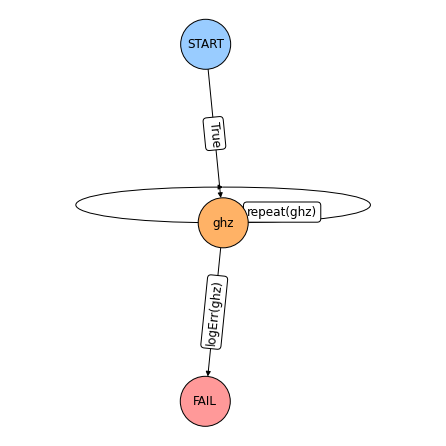

In [ ]:
from qsam.protocol import Protocol, draw_protocol
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ], ff_det=True)


def repeat(m):
    return len(m) < 3 and m[-1] == 1
    
def logErr(m):
    return len(m) >= 3 and m[-1] == 1 and m[-2] == 1 and m[-3] == 1

functions = {'logErr': logErr, 'repeat': repeat}

g = Protocol()
g._check_fns.update(functions)
g.add_nodes_from(['ghz'], circuits=[ghz])

g.add_edge('START', 'ghz', check='True')

g.add_edge('ghz', 'ghz', check='repeat(ghz)')
g.add_edge('ghz', 'FAIL', check='logErr(ghz)')

draw_protocol(g, figsize=(6,6))

Total:   0%|          | 0/5 [00:00<?, ?it/s]

p_phy=1.00E-03:   0%|          | 0/100 [00:00<?, ?it/s]

p_phy=5.62E-03:   0%|          | 0/100 [00:00<?, ?it/s]

p_phy=3.16E-02:   0%|          | 0/100 [00:00<?, ?it/s]

p_phy=1.78E-01:   0%|          | 0/100 [00:00<?, ?it/s]

p_phy=1.00E+00:   0%|          | 0/100 [00:00<?, ?it/s]

Rel. std target of 0.5 reached. Sampling stopped.


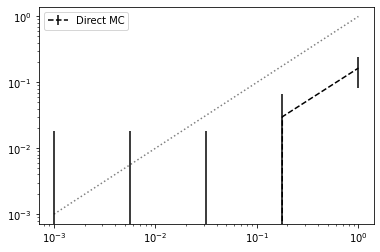

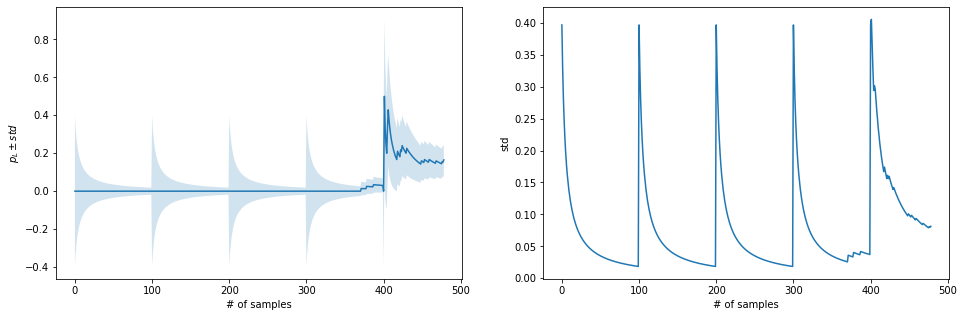

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator

sample_range = np.logspace(-3,0,5)
err_params = {'p': 1}

sam = Sampler(g, ChpSimulator)
sam.setup(sample_range, err_params)

callbacks = [
    cb.RelStdTarget(target=0.5),
    cb.PlotStats(sample_range),
    cb.StatsPerSample(),
    # cb.VerboseCircuitExec()
]
sam.run(n_samples=100, callbacks=callbacks)


In [ ]:
show_doc(Sampler)

<h2 id="Sampler" class="doc_header"><code>class</code> <code>Sampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Sampler</code>(**`protocol`**, **`simulator`**)



For the `SubsetSampler` we want to sample from specific fault-weight-subsets upto a certain maximum weight $w_{max}$. The benefit of this approach is that we can scale each of the resulting failure rates by analytically calculated `subset_occurances` for each `p_phy` which then gives us `p_L(p_phy)` for all `p_phy` without any additional sampling required. The subset sampler chooses the next fault-weight subset that is used when sampling from the next circuit in the protocol by the minimum sampled subset for a given circuit, which results in a balanced sampling over all subsets for a circuit. Additionally, one can exclude sampling for all circuits in a protocol from certain subsets by specifying a *list of ints* of `w_exclude` fault-weights. Overall, this approach of choosing the subsets and defining the weight threshold is not ideal. The dynamic subset sampler includes methods to improve on both of these points.

For subset sampling we need a new data structure to keep track of the circuit and circuit-subsets we are sampling from per protocol run. The natural structure for this problem is a Tree which we call `SampleTree`, populated with so-called `CountNodes`:

In [ ]:
#export
class CountNode(NodeMixin):
    def __init__(self, name, parent=None, children=None, counts=0, 
                 ckey=None, is_deterministic=False, is_fail=False):
        super(CountNode, self).__init__()
        
        self.name = name
        self.ckey = ckey
        self.counts = int(counts)
        self.is_deterministic = is_deterministic
        self.is_fail = is_fail
        
        self.parent = parent
        if children:
            self.children = children
            
    @property
    def rate(self):
        assert not self.ckey and not self.is_root
        if self.parent.counts < 2: return 0.5
        else: return self.counts / self.parent.counts

    @property
    def var(self, var_fn=math.Wilson_var):
        assert not self.ckey and not self.is_root
        if self.parent.counts < 2: return 1.0
        else: return var_fn(self.rate, self.parent.counts)
    
    def __str__(self):
        if self.is_root or self.ckey:
            return f'{self.name} ({self.counts})'
        else:
            return f'{self.name} ({self.counts}/{self.parent.counts}, {self.var:.2e})'

In [ ]:
#export
class SampleTree:
    def __init__(self, root=None):
        self.root = root
    
    def add(self, name, parent=None, **kwargs):
        if parent == None:
            if self.root == None:
                self.root = CountNode(name, **kwargs)
            return self.root
        else:
            child_match = [n for n in parent.children if n.name==name]
            if child_match: return child_match[0]
            else: return CountNode(name, parent=parent, **kwargs)
        
    def update(self, name, parent=None, **kwargs):
        node = self.add(name, parent, **kwargs)
        node.counts += 1
        return node
        
    def detach(self, node):
        node.parent = None
        
    def rate(self, const):
        p = 0
        for leaf in self.root.leaves:
            if not leaf.is_root and not leaf.parent.is_deterministic and leaf.is_fail: 
                prod = 1
                for n in leaf.path[1:]:
                    if n.ckey: prod *= const[n.ckey[0]][n.ckey[1]]
                    else: prod *= n.rate
                p += prod
        return p
    
    def var(self, const):
        var = 0
        for node in [n for n in self.root.descendants if not n.ckey]:
            if not node.parent.is_deterministic:
                twig = 1.0
                for n in node.path[1:-1]:
                    if n.ckey: twig *= const[n.ckey[0]][n.ckey[1]]
                    else: twig *= n.rate
                                    
                subtree = 0
                for leaf in node.leaves:
                    if not leaf.is_fail: # CHECK.
                        continue
                    
                    prod = 1
                    for n in leaf.iter_path_reverse():
                        if n == node: 
                            break
                        elif n.ckey: prod *= const[n.ckey[0]][n.ckey[1]]
                        else: prod *= n.rate
                                            
                    subtree += prod
                    
                var += node.var * twig**2 * subtree**2
        return var
    
    def delta(self, const):
        path_sum = 0.0
        for leaf in self.root.leaves:
            if not leaf.is_root:
                prod = 1.0
                for n in leaf.path[1:]:
                    if n.ckey: prod *= const[n.ckey[0]][n.ckey[1]]
                    else: prod *= n.rate
                path_sum += prod
        return 1.0 - path_sum
    
    def __str__(self):
        return '\n'.join([f'{pre}{node}' for pre, _, node in RenderTree(self.root)])
    
    def display(self, fname='temp.png'):
        
        # TODO: CHECK IF THIS LIB IS INSTALLED OTHERWISE RAISE.
        from anytree.exporter import UniqueDotExporter
        from IPython.display import Image, display ## ! requirements: jupyter, graphviz
        
        def edgeattrfunc(node, child):
            weight = 10.0 * child.counts / self.root.counts
            weight = 5.0 if weight > 5.0 else weight
            return f'penwidth="{weight}"'

        def nodeattrfunc(node):
            node_form = ""
            if node.is_fail: 
                node_form = ', style=filled, fillcolor="#ff9999"'
            return f'label="{node.name}"' + node_form

        img = UniqueDotExporter(self.root, 
                          edgeattrfunc=edgeattrfunc,
                          nodeattrfunc=nodeattrfunc).to_picture(fname)
        display(Image(fname))
        return fname
    
    def save(self, fname):
        exporter = JsonExporter(indent=2, sort_keys=False, default=str)
        with open(fname, 'w') as f:
            exporter.write(self.root, f)

    def load(self, fname):
        dictimporter = DictImporter(CountNode)
        importer = JsonImporter(dictimporter)
        with open(fname, 'r') as f:
            self.root = importer.read(f)
        return self

The subset sampler now keeps track of sampled nodes by altering the tree. As the tree is only created once a new sampler object is called, the sampling state is not lost after calling the `run()` method, which is particularly useful if one wants to continue sampling at a later point in time. Furthermore, a sampling tree can be saved to JSON and reloaded with the `tree.save` and `tree.load` functions.

In [ ]:
#export

class SubsetSampler:
    """Subset Sampler of quantum protocols"""
    
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
        self.tree = SampleTree()
        self.is_setup = False
        
    def setup(self, sample_range, err_params, p_max):
        p_max = np.array([p_max]) if isinstance(p_max, float) else np.array(p_max)
        assert len(p_max) == len(err_params)
        self.err_params = err_params
        self.partitions = protocol_partitions(self.protocol._circuits, err_params.keys())
        self.w_vecs = protocol_weight_vectors(self.partitions)
        self.Aws_pmax = protocol_subset_occurence(self.partitions, self.w_vecs, p_max)
        self.set_range(sample_range)
        self.is_setup = True
        
    def set_range(self, sample_range):
        p_phy_per_partition = np.array([[p_phy * mul for p_phy in sample_range] for mul in self.err_params.values()]).T
        self.Aws = protocol_subset_occurence(self.partitions, self.w_vecs, p_phy_per_partition)
        
    def stats(self, const='Aws', **kwargs):
        if const == 'Aws': Aws = self.Aws
        elif const == 'Aws_pmax': Aws = self.Aws_pmax
        v_L = self.tree.var(Aws)
        p_L = self.tree.rate(Aws)
        if isinstance(v_L, np.ndarray) and isinstance(p_L, int): 
            p_L = np.zeros_like(v_L)
        delta = self.tree.delta(Aws)
        return p_L, np.sqrt(v_L), delta
        
    def run(self, n_samples, callbacks=[], ss_filter_fn=w_plus1_filter, ss_sel_fn=ERV_sel):
        assert self.is_setup, 'Sampler not setup. Call setup(..) before run(..).'
        
        if not isinstance(callbacks, cb.CallbackList):
            callbacks = cb.CallbackList(sampler=self, callbacks=callbacks)
            
        self.stop_sampling = False
        callbacks.on_sampler_begin()
        
        for i in tqdm(range(n_samples), desc='Total'):
            
            callbacks.on_protocol_begin()
            
            sim = self.simulator(self.n_qubits)
            p_it = iterate(self.protocol)
            node = next(p_it)
            tree_node = None
            
            while True:
                
                callbacks.on_circuit_begin()
                
                tree_node = self.tree.update(name=node, parent=tree_node)
                if node == None: break
                elif not self.protocol.out_edges(node): tree_node.is_fail = True; break
                
                circuit_hash, circuit = self.protocol.circuit_from_node(node)
                if circuit_hash not in self.partitions.keys() or not circuit._noisy: # correction circuits
                    msmt = sim.run(circuit)
                else:
                    w_ids = [n.ckey[1] for n in tree_node.children]
                    w_ids = ss_filter_fn(sampler=self, **locals())
                    w_idx = ss_sel_fn(sampler=self, **locals())
                    w_vec = self.w_vecs[circuit_hash][w_idx]
                    tree_node = self.tree.update(name=w_vec, parent=tree_node, ckey=(circuit_hash, w_idx),
                                                is_deterministic=True if circuit._ff_deterministic and not any(w_vec) else False)

                    faults = Depolar.faults_from_weights(self.partitions[circuit_hash], w_vec)
                    fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                    msmt = sim.run(circuit, fault_circuit)
                
                _node = node
                node = p_it.send(msmt)
                callbacks.on_circuit_end(locals()) 
                
            callbacks.on_protocol_end() 
            if self.stop_sampling: break
            
        callbacks.on_sampler_end()

Total:   0%|          | 0/500 [00:00<?, ?it/s]

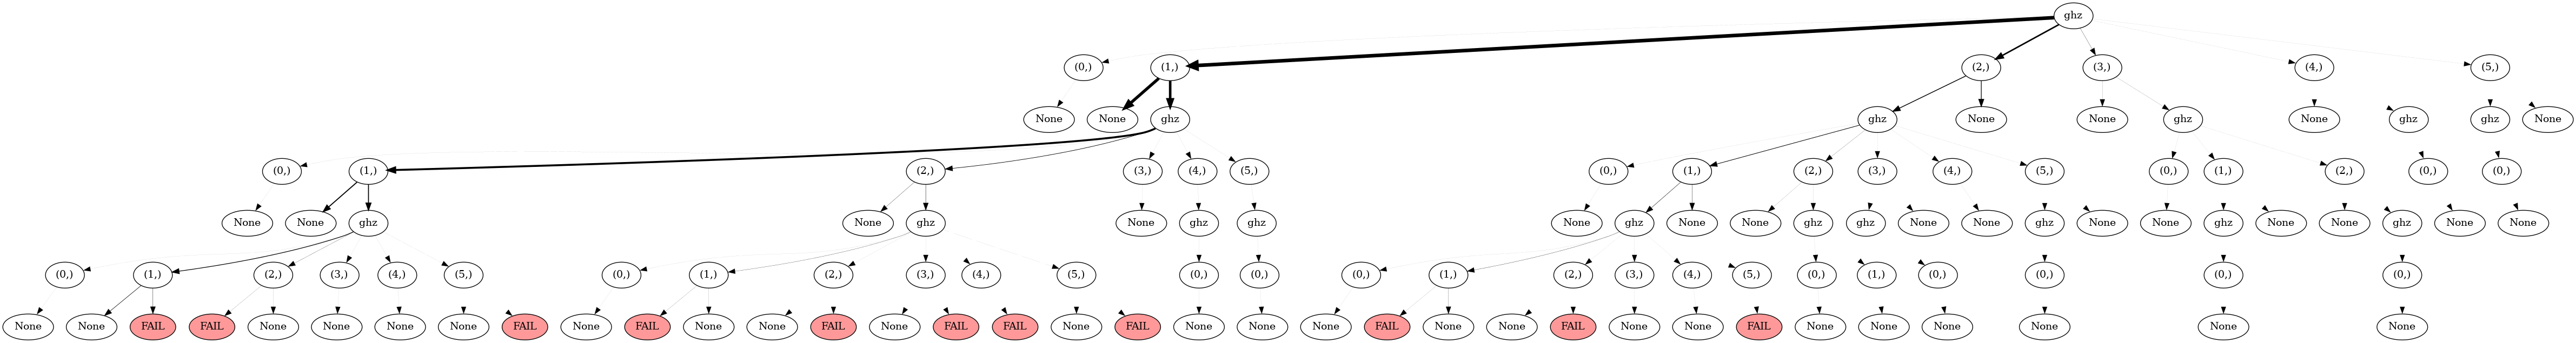

'temp.png'

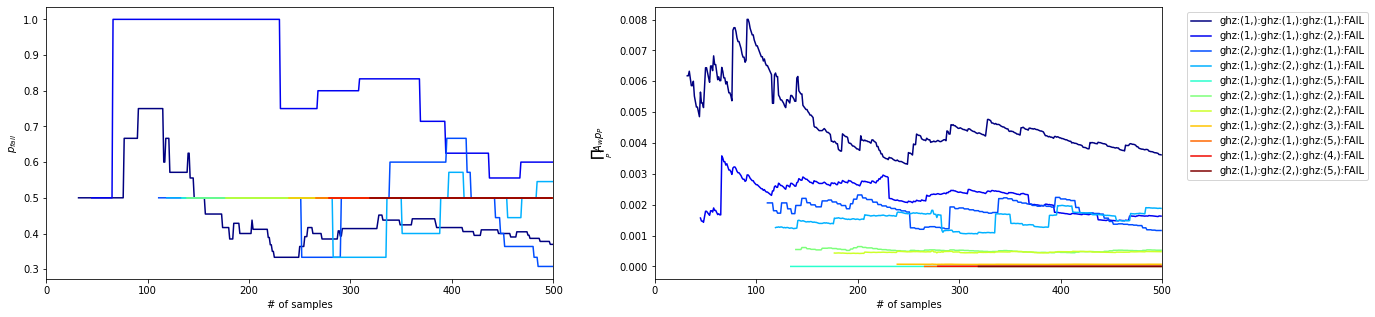

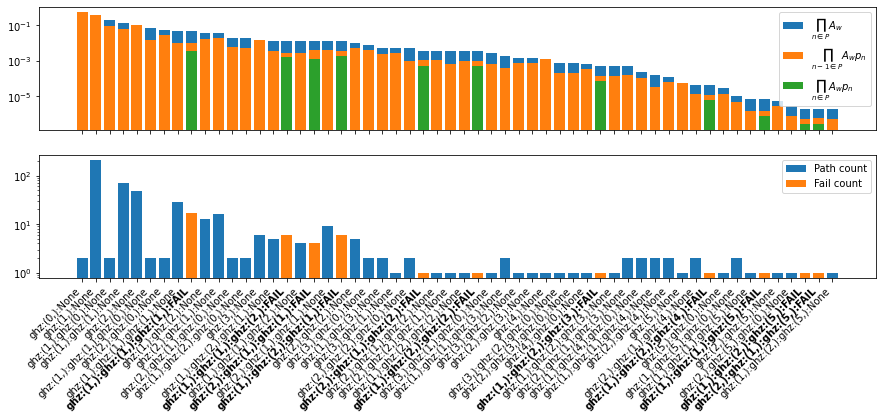

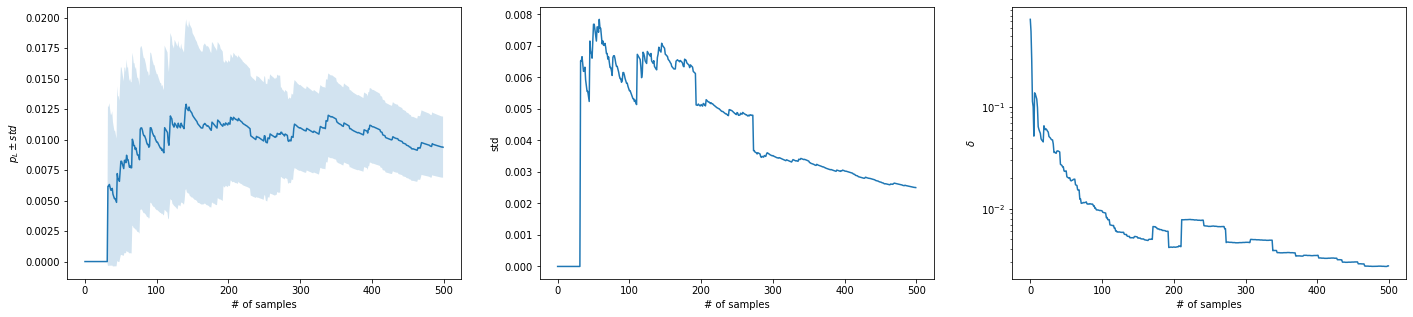

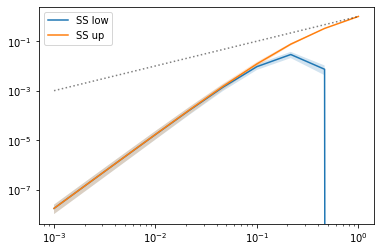

In [ ]:
#slow
from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}

sam = SubsetSampler(g, CHP)
sam.setup(sample_range, err_params, p_max=0.1)

callbacks = [
    cb.SubsetRates(),
    cb.PathProducts(),
    cb.RelStdTarget(target=0.01),
    cb.StatsPerSample(),
    cb.PlotStats(sample_range)
]
sam.run(500, callbacks=callbacks)
sam.tree.display()

In [ ]:
show_doc(SubsetSampler)

<h2 id="SubsetSampler" class="doc_header"><code>class</code> <code>SubsetSampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SubsetSampler</code>(**`protocol`**, **`simulator`**)

Subset Sampler of quantum protocols